# Likelihood Comparison Experiments (Full + Energy-Filtered Analysis)

This notebook performs three key experiments with **both full dataset and energy-filtered analyses**:
1. **EBM vs Flow Matching Likelihood**: Compare EBM likelihood (from potential forward pass) vs flow matching likelihood
2. **EBM vs Energies**: Compare EBM likelihood predictions vs actual energies stored in the data
3. **Flow Matching vs Energies**: Compare flow matching likelihoods vs actual energies stored in the data

## 📊 **Dual Analysis Approach**
- **Full Dataset Analysis**: Uses all available samples for comprehensive baseline results
- **Energy-Filtered Analysis**: Restricts to samples with energy < threshold (default: -60)
- **Comparative Results**: Shows how filtering affects correlations and metrics
- **Both sets of results are preserved** for comparison and validation

## 🔍 **Energy Filtering Details**
- **Configurable threshold** (default: energy < -60)
- Focuses analysis on more stable, lower-energy molecular configurations
- Removes high-energy outliers that may skew correlation analyses
- Results complement the full dataset analysis

## 📊 **Comprehensive Metrics**
Each experiment includes:
- **Correlation metrics**: Pearson R, Spearman R, R²
- **Error metrics**: MSE, MAE  
- **Effective Sample Size (ESS)**: Importance sampling efficiency
- **KL Divergence**: Distribution similarity measure
- **Statistical plots**: Scatter, residuals, distributions, Q-Q plots

The notebook is designed to work with `.npz` files containing dictionaries with samples, flow matching likelihoods, and energies.

## Setup and Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import entropy
from sklearn import metrics
from tqdm import tqdm
import wandb
import yaml
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import BG flow utilities for effective sample size
from bgflow.bg import effective_sample_size,sampling_efficiency

from models.interpolant import Interpolant
from models.ebm import GVP_EBM
from utils.utils import load_models
from dataset.ad2_dataset import get_alanine_atom_types, get_alanine_implicit_dataset, get_alanine_features

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3" #Swap this every time we run

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Imports completed successfully!")

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



Imports completed successfully!


## Configuration

**Configure the file paths and experiment settings below:**

In [2]:
# =============================================================================
# CONFIGURATION - UPDATE THESE PATHS WHEN DATA BECOMES AVAILABLE
# =============================================================================

# Model and data paths (to be provided later)
CONFIG = {
    # Model configuration
    'config_path': '../configs/infer_potential_graphormer_1b8ld256.yaml',  # Update this path
    
    # Data paths (UPDATE THESE WHEN DATA IS AVAILABLE)
    # FIXED: Using EBM-generated data to match the potential model config
    'data_file_path': "/net/galaxy/home/koes/rishal/nce/BoltzNCE/BoltzNCE/generated/vector_ot_ema_3_numpy_dict.npz",  # Path to .npz file containing samples and flow matching likelihoods
    
    # Expected keys in the .npz file dictionary
    'samples_key': 'samples',  # Key for samples in the .npz file
    'flow_likelihood_key': 'dlogf',  # Key for flow matching likelihoods in the .npz file
    'energies_key': 'energies',  # Key for energies in the .npz file
    
    # Experiment settings
    'experiment': 'all',  # 'ebm_vs_flow', 'ebm_vs_energy', 'flow_vs_energy', or 'all'
    'batch_size': 100,  # Batch size for processing samples
    'device': 'cuda',  # 'cuda' or 'cpu'
    
    # *** DUAL ANALYSIS: Both full and filtered ***
    'run_full_analysis': True,    # Run analysis on full dataset
    'run_filtered_analysis': True,  # Run analysis on energy-filtered dataset
    'energy_threshold': -75.0,   # Only analyze samples with energy < this value (for filtered analysis)
    
    # ODE solver settings for Hutchinson approximator
    'rtol': 1e-3,  # Relative tolerance for ODE solver
    'atol': 1e-3,  # Absolute tolerance for ODE solver
    'tmin': 0,  # Minimum time for integration
    
    # Output settings
    'output_dir': './likelihood_comparison_results/',
    'save_plots': True,
    'wandb_project': 'likelihood_comparisons',
    'wandb_run_name': None,  # Will auto-generate if None
}

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded:
  config_path: ../configs/infer_potential_graphormer_1b8ld256.yaml
  data_file_path: /net/galaxy/home/koes/rishal/nce/BoltzNCE/BoltzNCE/generated/vector_ot_ema_3_numpy_dict.npz
  samples_key: samples
  flow_likelihood_key: dlogf
  energies_key: energies
  experiment: all
  batch_size: 100
  device: cuda
  run_full_analysis: True
  run_filtered_analysis: True
  energy_threshold: -75.0
  rtol: 0.001
  atol: 0.001
  tmin: 0
  output_dir: ./likelihood_comparison_results/
  save_plots: True
  wandb_project: likelihood_comparisons
  wandb_run_name: None


In [3]:
def extract_keys(data, parent_key=''):
    """Recursively collect keys in a nested dict."""
    keys = []
    if isinstance(data, dict):
        for k, v in data.items():
            full_key = f"{parent_key}.{k}" if parent_key else k
            keys.append(full_key)
            keys.extend(extract_keys(v, full_key))
    return keys




## Utility Functions

In [4]:
def load_model_and_config(config_path, rtol, atol, tmin):
    """Load models and configuration using proper args structure."""
    if config_path is None:
        raise ValueError("Config path must be provided")
    
    # Load config file
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Create a proper args structure that matches what load_models expects
    # Start with the config and then override specific parameters
    args = config.copy()
    
    # Override ODE solver parameters
    if 'interpolant' not in args:
        args['interpolant'] = {}
    args['interpolant']['rtol'] = rtol
    args['interpolant']['atol'] = atol
    args['interpolant']['tmin'] = tmin
    
    # Get dataset info for model initialization
    h_initial = get_alanine_features()
    
    # Load models using existing utility with proper args structure
    # The potential_function is properly passed during interpolant initialization
    potential_model, vector_field, interpolant_obj = load_models(args, h_initial)
    
    # DO NOT manually override the potential_function - it's already set correctly
    # interpolant_obj.potential_function = potential_model  # REMOVED - This was wrong!
    
    if potential_model is not None:
        potential_model.eval()
    if vector_field is not None:
        vector_field.eval()
        
    return potential_model, vector_field, interpolant_obj, config


def get_ebm_likelihood_from_potential(interpolant_obj, samples, batch_size=1000):
    """
    Compute EBM likelihood using potential model forward pass.
    Based on get_potential_logp() from infer_ad2.py:131
    """
    print("Computing EBM likelihoods from potential forward pass...")
    
    dlogf_all = []
    samples_torch = torch.from_numpy(samples).float().to('cuda')
    samples_torch = samples_torch / interpolant_obj.scaling
    
    # Process in batches
    for i in range(0, len(samples_torch), batch_size):
        end_idx = min(i + batch_size, len(samples_torch))
        samples_batch = samples_torch[i:end_idx]
        
        with torch.no_grad():
            dlogf = interpolant_obj.log_prob_forward(samples_batch)
            dlogf_all.append(dlogf.cpu().detach())
        
        if i % (batch_size * 10) == 0:
            print(f"  Processed {end_idx}/{len(samples_torch)} samples")
    
    # Concatenate results
    dlogf_all = torch.cat(dlogf_all, dim=0)
    
    # *** CRITICAL NORMALIZATION STEP - SAME AS infer_ad2.py:146 ***
    # This converts raw potential outputs to normalized log probabilities, normalization shouldnt affect this tho
    # dlogf_all = dlogf_all - torch.logsumexp(dlogf_all, dim=(0,1))
    
    print(f"  Completed! Shape: {dlogf_all.shape}")
    return dlogf_all.numpy()


def get_hutchinson_likelihood_reverse(interpolant_obj, samples,m=1, batch_size=500):
    """
    Compute likelihood using Hutchinson's estimator via reverse integration.
    Based on  from interpolant.py:276
    """
    print("Computing likelihoods using Hutchinson's approximator (reverse integral)...")
    
    nll_all = []
    samples_torch = torch.from_numpy(samples).float().to('cuda')
    
    # Process in batches 
    for i in tqdm(range(0, len(samples_torch), batch_size)):
        end_idx = min(i + batch_size, len(samples_torch))
        samples_batch = samples_torch[i:end_idx]
    
        
        with torch.no_grad():
            # This performs reverse integration with Hutchinson's estimator
            nll = interpolant_obj.NLL_integral_with_hutchinsons(samples_batch,m)
            nll_all.append(nll.cpu().detach())
            
    
    # Concatenate results
    nll_all = torch.cat(nll_all, dim=0)
    
    print(f"  Completed! Shape: {nll_all.shape}")
    return nll_all.numpy()


def compute_effective_sample_size(log_weights):
    """
    Compute effective sample size from log weights.
    Based on bgflow.bg.effective_sample_size
    """
    if isinstance(log_weights, np.ndarray):
        log_weights = torch.from_numpy(log_weights).float()
    
    # Ensure log_weights is 2D
    if log_weights.dim() == 1:
        log_weights = log_weights.unsqueeze(-1)
    
    # Compute ESS using bgflow utility
    ess = effective_sample_size(log_weights)
    
    return float(ess.item())


def compute_kl_divergence_discrete(pred_ll, true_ll, n_bins=100):
    """
    Compute KL divergence between predicted and true likelihood distributions.
    Uses discrete approximation via histograms.
    """
    # Flatten arrays
    pred_flat = pred_ll.flatten()
    true_flat = true_ll.flatten()
    
    # Create common bin edges based on combined range
    combined_min = min(pred_flat.min(), true_flat.min())
    combined_max = max(pred_flat.max(), true_flat.max())
    bins = np.linspace(combined_min, combined_max, n_bins + 1)
    
    # Compute histograms (normalized to form probability distributions)
    pred_hist, _ = np.histogram(pred_flat, bins=bins, density=True)
    true_hist, _ = np.histogram(true_flat, bins=bins, density=True)
    
    # Normalize to sum to 1 (convert density to probability)
    bin_width = bins[1] - bins[0]
    pred_hist = pred_hist * bin_width
    true_hist = true_hist * bin_width
    
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    pred_hist = pred_hist + epsilon
    true_hist = true_hist + epsilon
    
    # Compute KL divergence: KL(true || pred) = sum(true * log(true / pred))
    kl_div = entropy(true_hist, pred_hist)
    
    return kl_div


def compute_comparison_metrics(predicted_ll, true_ll, experiment_name):
    """Compute various comparison metrics between predicted and true likelihoods."""
    
    # Flatten arrays
    pred_flat = predicted_ll.flatten()
    true_flat = true_ll.flatten()
    
    # Basic statistics
    mse = np.mean((pred_flat - true_flat) ** 2)
    mae = np.mean(np.abs(pred_flat - true_flat))
    
    # Correlation
    pearson_r, pearson_p = stats.pearsonr(pred_flat, true_flat)
    spearman_r, spearman_p = stats.spearmanr(pred_flat, true_flat)
    
    # R-squared
    r2 = metrics.r2_score(true_flat, pred_flat)
    
    # *** NEW: Effective Sample Size ***
    # Compute log weights as difference between true and predicted likelihoods
    log_weights = pred_flat - true_flat 
    ess = sampling_efficiency(torch.tensor(log_weights))
    ess_ratio = ess / len(pred_flat)  # ESS as fraction of total samples
    
    # *** NEW: KL Divergence ***
    kl_divergence = compute_kl_divergence_discrete(pred_flat, true_flat)
    
    metrics_dict = {
        f'{experiment_name}_mse': mse,
        f'{experiment_name}_mae': mae,
        f'{experiment_name}_pearson_r': pearson_r,
        f'{experiment_name}_pearson_p': pearson_p,
        f'{experiment_name}_spearman_r': spearman_r,
        f'{experiment_name}_spearman_p': spearman_p,
        f'{experiment_name}_r2': r2,
        f'{experiment_name}_ess': ess,
        f'{experiment_name}_ess_ratio': ess_ratio,
        f'{experiment_name}_kl_divergence': kl_divergence,
        f'{experiment_name}_pred_mean': np.mean(pred_flat),
        f'{experiment_name}_pred_std': np.std(pred_flat),
        f'{experiment_name}_true_mean': np.mean(true_flat),
        f'{experiment_name}_true_std': np.std(true_flat)
    }
    
    return metrics_dict


def create_comparison_plots(predicted_ll, true_ll, experiment_name, output_dir=None):
    """Create comparison plots between predicted and true likelihoods."""
    
    # Flatten arrays
    pred_flat = predicted_ll.flatten()
    true_flat = true_ll.flatten()
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{experiment_name} Likelihood Comparison', fontsize=16, fontweight='bold')
    
    # Scatter plot
    axes[0, 0].scatter(true_flat, pred_flat, alpha=0.6, s=1)
    axes[0, 0].plot([true_flat.min(), true_flat.max()], 
                    [true_flat.min(), true_flat.max()], 'r--', alpha=0.8, linewidth=2)
    axes[0, 0].set_xlabel('True Likelihood')
    axes[0, 0].set_ylabel('Predicted Likelihood')
    axes[0, 0].set_title('Predicted vs True')
    axes[0, 0].set_xlim(-200,200)
    axes[0, 0].set_ylim(-200,200)
    axes[0, 0].set_title('Predicted vs True')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals plot
    residuals = pred_flat - true_flat
    axes[0, 1].scatter(true_flat, residuals, alpha=0.6, s=1)
    axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8, linewidth=2)
    axes[0, 1].set_xlabel('True Likelihood')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals vs True')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim(-200,200)
    axes[0, 1].set_ylim(-200,200)
    
    # Distribution comparison
    axes[1, 0].hist(true_flat, bins=50, alpha=0.7, label='True', density=True, color='blue')
    axes[1, 0].hist(pred_flat, bins=50, alpha=0.7, label='Predicted', density=True, color='orange')
    axes[1, 0].set_xlabel('Likelihood')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[0, 1].set_xlim(-200,200)
    axes[0, 1].set_ylim(-200,200)
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot of Residuals')
    axes[1, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim(-200,200)
    axes[0, 1].set_ylim(-200,200)
    plt.tight_layout()
    
    # Save plot if output directory specified
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        plot_path = output_dir / f'{experiment_name.lower()}_comparison.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {plot_path}")
    
    plt.show()
    
    return fig


def run_single_experiment(experiment_num, experiment_name, predicted_ll, true_ll, samples, dataset_type, output_dir):
    """Run a single experiment analysis and return metrics."""
    
    print(f"\n" + "="*80)
    print(f"EXPERIMENT {experiment_num}: {experiment_name}")
    print(f"📊 DATASET: {dataset_type} ({len(samples)} samples)")
    print("="*80)
    
    # Compute metrics
    exp_key = experiment_name.lower().replace(' ', '_').replace('vs', '_vs')
    if dataset_type == "Filtered":
        exp_key += "_filtered"
    
    metrics = compute_comparison_metrics(predicted_ll, true_ll, exp_key)
    
    # Display metrics
    print(f"\n📊 {experiment_name} Comparison Metrics ({dataset_type}):")
    print(f"   MSE: {metrics[f'{exp_key}_mse']:.6f}")
    print(f"   MAE: {metrics[f'{exp_key}_mae']:.6f}")
    print(f"   Pearson R: {metrics[f'{exp_key}_pearson_r']:.4f} (p={metrics[f'{exp_key}_pearson_p']:.2e})")
    print(f"   Spearman R: {metrics[f'{exp_key}_spearman_r']:.4f} (p={metrics[f'{exp_key}_spearman_p']:.2e})")
    print(f"   R²: {metrics[f'{exp_key}_r2']:.4f}")
    print(f"   🔢 Effective Sample Size: {metrics[f'{exp_key}_ess']:.7f} ({metrics[f'{exp_key}_ess_ratio']:.7f} ratio)")
    print(f"   📏 KL Divergence: {metrics[f'{exp_key}_kl_divergence']:.6f}")
    
    print(f"\n📈 Data Statistics:")
    print(f"   Predicted - Mean: {metrics[f'{exp_key}_pred_mean']:.4f}, Std: {metrics[f'{exp_key}_pred_std']:.4f}")
    print(f"   True      - Mean: {metrics[f'{exp_key}_true_mean']:.4f}, Std: {metrics[f'{exp_key}_true_std']:.4f}")
    
    # Create plots
    plot_name = f"{experiment_name.replace(' ', '_')}_{dataset_type}"
    # create_comparison_plots(predicted_ll, true_ll, plot_name, output_dir)

    return metrics

print("Utility functions loaded successfully!")

Utility functions loaded successfully!


## Initialize Experiment

In [5]:
# Initialize wandb if requested
# if CONFIG['wandb_project']:
#     wandb.init(
#         project=CONFIG['wandb_project'],
#         name=CONFIG['wandb_run_name'],
#         config=CONFIG
#     )
#     print("Wandb initialized")

# print("\n" + "="*60)
# print("LIKELIHOOD COMPARISON EXPERIMENTS")
# print("="*60)
# print(f"Device: {CONFIG['device']}")
# print(f"Experiment: {CONFIG['experiment']}")
# print(f"Output directory: {CONFIG['output_dir']}")

## Load Models and Data

In [6]:
# Load models and config
try:
    potential_model, vector_field, interpolant_obj, config = load_model_and_config(
        CONFIG['config_path'], CONFIG['rtol'], CONFIG['atol'], CONFIG['tmin']
    )
    print("✅ Models loaded successfully")
    print(f"   - Potential model: {potential_model is not None}")
    print(f"   - Vector field: {vector_field is not None}")
    print(f"   - Interpolant: {interpolant_obj is not None}")
except Exception as e:
    print(f"❌ Error loading models: {e}")
    raise

Total number of parameters in potential model: 4879949
Loaded potential model from saved_models/trained_potential_trig_graphormer_1b8ld256_2.pt
Total number of parameters in vector field model: 108933
Loaded vector field model from saved_models/trained_vector_5_layer_ot_ema.pt
✅ Models loaded successfully
   - Potential model: True
   - Vector field: True
   - Interpolant: True


In [7]:
# Load data from .npz file
if CONFIG['data_file_path'] is None:
    print("⚠️  Warning: data_file_path not provided. Please update CONFIG['data_file_path'] when data is available.")
    samples = None
    flow_matching_ll = None
    energies = None
else:
    try:
        # Load .npz file which contains a dictionary
        data_dict = np.load(CONFIG['data_file_path'])
        keys= extract_keys(data_dict)
    
        # Extract samples, flow matching likelihoods, and energies using configured keys
        samples = data_dict[CONFIG['samples_key']]
        flow_matching_ll = (-data_dict["energies"] - data_dict["log_w"]) ## this is cause theres a bug in how we saved the ll, but lukcliy we can back compute it
        energies = data_dict[CONFIG['energies_key']]
        
        print(f"✅ Loaded data from: {CONFIG['data_file_path']}")
        print(f"   - Available keys: {list(data_dict.keys())}")
        print(f"   - Samples shape: {samples.shape}")
        print(f"   - Sample range: [{samples.min():.3f}, {samples.max():.3f}]")
        print(f"   - Sample mean: {samples.mean():.3f}")
        print(f"   - Sample std: {samples.std():.3f}")
        print(f"   - Flow likelihoods shape: {flow_matching_ll.shape}")
        print(f"   - Flow likelihood range: [{flow_matching_ll.min():.3f}, {flow_matching_ll.max():.3f}]")
        print(f"   - Flow likelihood mean: {flow_matching_ll.mean():.3f}")
        print(f"   - Energies shape: {energies.shape}")
        print(f"   - Energy range: [{energies.min():.3f}, {energies.max():.3f}]")
        print(f"   - Energy mean: {energies.mean():.3f}")
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        print(f"   Make sure the file exists and contains keys: '{CONFIG['samples_key']}', '{CONFIG['flow_likelihood_key']}', and '{CONFIG['energies_key']}'")
        samples = None
        flow_matching_ll = None
        energies = None

✅ Loaded data from: /net/galaxy/home/koes/rishal/nce/BoltzNCE/BoltzNCE/generated/vector_ot_ema_3_numpy_dict.npz
   - Available keys: ['samples', 'log_w', 'dlogf', 'energies']
   - Samples shape: (100000, 66)
   - Sample range: [-5.098, 5.295]
   - Sample mean: 0.000
   - Sample std: 1.618
   - Flow likelihoods shape: (100000, 1)
   - Flow likelihood range: [72.325, 1394.525]
   - Flow likelihood mean: 105.016
   - Energies shape: (100000, 1)
   - Energy range: [-108.278, 8345.485]
   - Energy mean: -86.475


In [8]:
# Data is now loaded from the single .npz file above
print("📋 Data Summary:")
if samples is not None and flow_matching_ll is not None and energies is not None:
    print(f"   ✅ Samples loaded: {samples.shape}")
    print(f"   ✅ Flow matching likelihoods loaded: {flow_matching_ll.shape}")
    print(f"   ✅ Energies loaded: {energies.shape}")
    
    # Store original (full) dataset
    samples_full = samples.copy()
    flow_matching_ll_full = flow_matching_ll.copy()
    energies_full = energies.copy()
    
    print(f"\n📊 Full Dataset Statistics:")
    print(f"   Sample range: [{samples_full.min():.3f}, {samples_full.max():.3f}]")
    print(f"   Sample mean: {samples_full.mean():.3f}, std: {samples_full.std():.3f}")
    print(f"   Flow likelihood range: [{flow_matching_ll_full.min():.3f}, {flow_matching_ll_full.max():.3f}]")
    print(f"   Flow likelihood mean: {flow_matching_ll_full.mean():.3f}")
    print(f"   Energy range: [{energies_full.min():.3f}, {energies_full.max():.3f}]")
    print(f"   Energy mean: {energies_full.mean():.3f}")
    
    # Prepare filtered dataset if requested
    if CONFIG['run_filtered_analysis']:
        print(f"\n🔍 PREPARING FILTERED DATASET: energy < {CONFIG['energy_threshold']}")
        
        # Create mask for samples with energy < threshold
        energy_mask = energies_full.flatten() < CONFIG['energy_threshold']
        n_total = len(energies_full)
        n_filtered = np.sum(energy_mask)
        
        print(f"   📊 Total samples: {n_total}")
        print(f"   📊 Filtered samples: {n_filtered} ({n_filtered/n_total*100:.1f}%)")
        print(f"   📊 Removed samples: {n_total - n_filtered} ({(n_total - n_filtered)/n_total*100:.1f}%)")
        
        if n_filtered == 0:
            print("   ❌ ERROR: No samples satisfy the energy criterion!")
            print(f"   💡 Current energy range: [{energies_full.min():.3f}, {energies_full.max():.3f}]")
            print(f"   💡 Consider adjusting energy_threshold above {energies_full.min():.3f}")
            CONFIG['run_filtered_analysis'] = False
            samples_filtered = None
            flow_matching_ll_filtered = None
            energies_filtered = None
        else:
            # Apply filter to create filtered datasets
            samples_filtered = samples_full[energy_mask]
            flow_matching_ll_filtered = flow_matching_ll_full[energy_mask]
            energies_filtered = energies_full[energy_mask]
            
            print(f"\n📈 Filtered Dataset Statistics:")
            print(f"   Sample range: [{samples_filtered.min():.3f}, {samples_filtered.max():.3f}]")
            print(f"   Sample mean: {samples_filtered.mean():.3f}, std: {samples_filtered.std():.3f}")
            print(f"   Flow likelihood range: [{flow_matching_ll_filtered.min():.3f}, {flow_matching_ll_filtered.max():.3f}]")
            print(f"   Flow likelihood mean: {flow_matching_ll_filtered.mean():.3f}")
            print(f"   Energy range: [{energies_filtered.min():.3f}, {energies_filtered.max():.3f}]")
            print(f"   Energy mean: {energies_filtered.mean():.3f}")
    else:
        samples_filtered = None
        flow_matching_ll_filtered = None
        energies_filtered = None
    
    print(f"\n📊 ANALYSIS PLAN:")
    if CONFIG['run_full_analysis']:
        print(f"   ✅ Full dataset analysis: {len(samples_full)} samples")
    if CONFIG['run_filtered_analysis'] and samples_filtered is not None:
        print(f"   ✅ Filtered dataset analysis: {len(samples_filtered)} samples (energy < {CONFIG['energy_threshold']})")
    print(f"   🔬 Ready for experiments!")
        
else:
    print(f"   ⚠️  Data not loaded. Please update CONFIG['data_file_path'] with the path to your .npz file.")
    samples_full = None
    flow_matching_ll_full = None
    energies_full = None
    samples_filtered = None
    flow_matching_ll_filtered = None
    energies_filtered = None

📋 Data Summary:
   ✅ Samples loaded: (100000, 66)
   ✅ Flow matching likelihoods loaded: (100000, 1)
   ✅ Energies loaded: (100000, 1)

📊 Full Dataset Statistics:
   Sample range: [-5.098, 5.295]
   Sample mean: 0.000, std: 1.618
   Flow likelihood range: [72.325, 1394.525]
   Flow likelihood mean: 105.016
   Energy range: [-108.278, 8345.485]
   Energy mean: -86.475

🔍 PREPARING FILTERED DATASET: energy < -75.0
   📊 Total samples: 100000
   📊 Filtered samples: 92983 (93.0%)
   📊 Removed samples: 7017 (7.0%)

📈 Filtered Dataset Statistics:
   Sample range: [-5.098, 5.295]
   Sample mean: 0.000, std: 1.619
   Flow likelihood range: [83.286, 1394.525]
   Flow likelihood mean: 105.822
   Energy range: [-108.278, -75.000]
   Energy mean: -87.944

📊 ANALYSIS PLAN:
   ✅ Full dataset analysis: 100000 samples
   ✅ Filtered dataset analysis: 92983 samples (energy < -75.0)
   🔬 Ready for experiments!


## Experiment 1: EBM vs Flow Matching Likelihood (Full + Filtered Analysis)

This experiment compares the EBM likelihood (calculated from the potential forward pass) against the flow matching likelihood. Since the EBM is trained to predict the flow matching likelihood, these should ideally be similar.

In [9]:
# # Run Experiment 1: EBM vs Flow Matching Likelihood
all_metrics = {}
# 
# if CONFIG['experiment'] in ['ebm_vs_flow', 'all']:
    
#     # Run on full dataset
#     if CONFIG['run_full_analysis'] and samples_full is not None and flow_matching_ll_full is not None:
#         predicted_ebm_ll_full = get_ebm_likelihood_from_potential(interpolant_obj, samples_full, CONFIG['batch_size'])
#         metrics_full = run_single_experiment(
#             1, "EBM vs Flow Matching", predicted_ebm_ll_full, flow_matching_ll_full, 
#             samples_full, "Full", CONFIG['output_dir']
#         )
#         all_metrics.update(metrics_full)
        
#         # Save EBM predictions
#         output_dir = Path(CONFIG['output_dir'])
#         output_dir.mkdir(parents=True, exist_ok=True)
#         np.save(output_dir / 'predicted_ebm_likelihoods_full.npy', predicted_ebm_ll_full)
#         print(f"💾 Saved full EBM predictions to: {output_dir / 'predicted_ebm_likelihoods_full.npy'}")
    
#     # Run on filtered dataset
#     if CONFIG['run_filtered_analysis'] and samples_filtered is not None and flow_matching_ll_filtered is not None:
#         predicted_ebm_ll_filtered = get_ebm_likelihood_from_potential(interpolant_obj, samples_filtered, CONFIG['batch_size'])
#         metrics_filtered = run_single_experiment(
#             1, "EBM vs Flow Matching", predicted_ebm_ll_filtered, flow_matching_ll_filtered, 
#             samples_filtered, "Filtered", CONFIG['output_dir']
#         )
#         all_metrics.update(metrics_filtered)
        
#         # Save EBM predictions
#         output_dir = Path(CONFIG['output_dir'])
#         output_dir.mkdir(parents=True, exist_ok=True)
#         np.save(output_dir / 'predicted_ebm_likelihoods_filtered.npy', predicted_ebm_ll_filtered)
#         print(f"💾 Saved filtered EBM predictions to: {output_dir / 'predicted_ebm_likelihoods_filtered.npy'}")

# else:
#     print("⚠️  Skipping EBM vs Flow Matching experiment - not requested")
#     predicted_ebm_ll_full = None
#     predicted_ebm_ll_filtered = None

In [10]:
## Experiment 2: EBM vs Energies (Full + Filtered Analysis)

# This experiment compares the EBM likelihood predictions against the actual energies stored in the data file. This helps us understand how well the EBM correlates with the underlying energy landscape.

In [11]:
all_metrics = {}
# Run Experiment 2: EBM vs Energies
if CONFIG['experiment'] in ['ebm_vs_energy', 'all']:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_full is not None and energies_full is not None:
        # Use EBM predictions from experiment 1 if available, otherwise compute
        if 'predicted_ebm_ll_full' not in locals() or predicted_ebm_ll_full is None:
            predicted_ebm_ll_full = get_ebm_likelihood_from_potential(interpolant_obj, samples_full, CONFIG['batch_size'])
        
        metrics_full = run_single_experiment(
            2, "EBM vs Energies", predicted_ebm_ll_full, energies_full, 
            samples_full, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)
    
    # Run on filtered dataset  
    if CONFIG['run_filtered_analysis'] and samples_filtered is not None and energies_filtered is not None:
        # Use EBM predictions from experiment 1 if available, otherwise compute
        if 'predicted_ebm_ll_filtered' not in locals() or predicted_ebm_ll_filtered is None:
            predicted_ebm_ll_filtered = get_ebm_likelihood_from_potential(interpolant_obj, samples_filtered, CONFIG['batch_size'])
        
        metrics_filtered = run_single_experiment(
            2, "EBM vs Energies", predicted_ebm_ll_filtered, energies_filtered, 
            samples_filtered, "Filtered", CONFIG['output_dir']
        )
        all_metrics.update(metrics_filtered)

else:
    print("⚠️  Skipping EBM vs Energies experiment - not requested")

Computing EBM likelihoods from potential forward pass...
  Processed 100/100000 samples
  Processed 1100/100000 samples
  Processed 2100/100000 samples
  Processed 3100/100000 samples
  Processed 4100/100000 samples
  Processed 5100/100000 samples
  Processed 6100/100000 samples
  Processed 7100/100000 samples
  Processed 8100/100000 samples
  Processed 9100/100000 samples
  Processed 10100/100000 samples
  Processed 11100/100000 samples
  Processed 12100/100000 samples
  Processed 13100/100000 samples
  Processed 14100/100000 samples
  Processed 15100/100000 samples
  Processed 16100/100000 samples
  Processed 17100/100000 samples
  Processed 18100/100000 samples
  Processed 19100/100000 samples
  Processed 20100/100000 samples
  Processed 21100/100000 samples
  Processed 22100/100000 samples
  Processed 23100/100000 samples
  Processed 24100/100000 samples
  Processed 25100/100000 samples
  Processed 26100/100000 samples
  Processed 27100/100000 samples
  Processed 28100/100000 sampl

In [12]:
## Experiment 3: Flow Matching vs Energies (Full + Filtered Analysis)

# This experiment compares the flow matching likelihoods against the actual energies stored in the data file. This helps us understand the relationship between flow matching predictions and the true energy landscape.

In [13]:
test = (data_dict["energies"] - data_dict["log_w"]) - data_dict["dlogf"]
test

array([[16634.45647519],
       [ 2921.49637537],
       [ 1081.90861018],
       ...,
       [ -214.85188397],
       [ -213.91388156],
       [ -216.8983078 ]])

In [14]:
# Run Experiment 3: Flow Matching vs Energies
test = (-data_dict["energies"] - data_dict["log_w"])
if CONFIG['experiment'] in ['back_flow_vs_energy', 'all']:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and flow_matching_ll_full is not None and energies_full is not None:
        metrics_full = run_single_experiment(
            3, "True Flow Matching vs Energies", flow_matching_ll_full, energies_full, 
            samples_full, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)
    
    # Run on filtered dataset
    if CONFIG['run_filtered_analysis'] and flow_matching_ll_filtered is not None and energies_filtered is not None:
        metrics_filtered = run_single_experiment(
            3, "True Flow Matching vs Energies", flow_matching_ll_filtered, energies_filtered, 
            samples_filtered, "Filtered", CONFIG['output_dir']
        )
        all_metrics.update(metrics_filtered)

else:
    print("⚠️  Skipping Flow Matching vs Energies experiment - not requested")


EXPERIMENT 3: True Flow Matching vs Energies
📊 DATASET: Full (100000 samples)

📊 True Flow Matching vs Energies Comparison Metrics (Full):
   MSE: 37667.322958
   MAE: 191.694318
   Pearson R: -0.1384 (p=0.00e+00)
   Spearman R: -0.7954 (p=0.00e+00)
   R²: -45.8399
   🔢 Effective Sample Size: 0.0000100 (0.0000000 ratio)
   📏 KL Divergence: 23.017924

📈 Data Statistics:
   Predicted - Mean: 105.0161, Std: 10.5521
   True      - Mean: -86.4754, Std: 28.3579

EXPERIMENT 3: True Flow Matching vs Energies
📊 DATASET: Filtered (92983 samples)

📊 True Flow Matching vs Energies Comparison Metrics (Filtered):
   MSE: 37738.819900
   MAE: 193.765955
   Pearson R: -0.4087 (p=0.00e+00)
   Spearman R: -0.7582 (p=0.00e+00)
   R²: -1042.4263
   🔢 Effective Sample Size: 0.0000108 (0.0000000 ratio)
   📏 KL Divergence: 22.312218

📈 Data Statistics:
   Predicted - Mean: 105.8219, Std: 10.3269
   True      - Mean: -87.9441, Std: 6.0140


In [15]:

    
# Run Experiment 2: EBM vs Energies
if CONFIG['experiment'] in ['ebm_vs_energy', 'all']:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_full is not None and energies_full is not None:
        # Use EBM predictions from experiment 1 if available, otherwise compute
        if 'predicted_ebm_ll_full' not in locals() or predicted_ebm_ll_full is None:
            predicted_ebm_ll_full = get_ebm_likelihood_from_potential(interpolant_obj, samples_full, CONFIG['batch_size'])
        
        metrics_full = run_single_experiment(
            2, "EBM vs Flow Matching", predicted_ebm_ll_full, flow_matching_ll_full, 
            samples_full, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)
    
    # Run on filtered dataset  
    if CONFIG['run_filtered_analysis'] and samples_filtered is not None and energies_filtered is not None:
        # Use EBM predictions from experiment 1 if available, otherwise compute
        if 'predicted_ebm_ll_filtered' not in locals() or predicted_ebm_ll_filtered is None:
            predicted_ebm_ll_filtered = get_ebm_likelihood_from_potential(interpolant_obj, samples_filtered, CONFIG['batch_size'])
        
        metrics_filtered = run_single_experiment(
            2, "EBM vs Flow Matching", predicted_ebm_ll_filtered, flow_matching_ll_filtered, 
            samples_filtered, "Filtered", CONFIG['output_dir']
        )
        all_metrics.update(metrics_filtered)

else:
    print("⚠️  Skipping EBM vs Energies experiment - not requested")


EXPERIMENT 2: EBM vs Flow Matching
📊 DATASET: Full (100000 samples)

📊 EBM vs Flow Matching Comparison Metrics (Full):
   MSE: 8164.721253
   MAE: 89.932860
   Pearson R: 0.5583 (p=0.00e+00)
   Spearman R: 0.9416 (p=0.00e+00)
   R²: -72.3273
   🔢 Effective Sample Size: 0.0010974 (0.0000000 ratio)
   📏 KL Divergence: 22.317207

📈 Data Statistics:
   Predicted - Mean: 15.0833, Std: 6.2933
   True      - Mean: 105.0161, Std: 10.5521

EXPERIMENT 2: EBM vs Flow Matching
📊 DATASET: Filtered (92983 samples)

📊 EBM vs Flow Matching Comparison Metrics (Filtered):
   MSE: 8156.573907
   MAE: 89.870867
   Pearson R: 0.5023 (p=0.00e+00)
   Spearman R: 0.9320 (p=0.00e+00)
   R²: -75.4832
   🔢 Effective Sample Size: 0.0010601 (0.0000000 ratio)
   📏 KL Divergence: 22.299081

📈 Data Statistics:
   Predicted - Mean: 15.9510, Std: 5.4431
   True      - Mean: 105.8219, Std: 10.3269


## Hutchinson's Reverse Integration Experiment

This section performs Hutchinson's reverse integration from the data samples and compares the results with EBM predictions. This provides an alternative likelihood estimation method using the reverse ODE integration with divergence estimation.

In [16]:
# ============================================================================
# HUTCHINSON'S REVERSE INTEGRATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("              HUTCHINSON'S REVERSE INTEGRATION EXPERIMENT")
print("="*80)

# Run Hutchinson's analysis on both datasets if available
hutchinson_metrics = {}
potential_model, vector_field, interpolant_obj, = potential_model.to("cuda"), vector_field.to("cuda"), interpolant_obj.to("cuda")

# 1. Create a random permutation of indices 0..N-1
perm = np.random.permutation(samples_full.shape[0])

# 2. Select the first 5000 of those permuted indices
selected_idx = perm[:10000]
mask = mask = np.zeros(samples_full.shape[0], dtype=bool)
mask[selected_idx] = True


samples_5000 = samples_full[mask]
energies_5000 = energies_full[mask]
flow_matching_ll_5000 = flow_matching_ll[mask]
predicted_ebm_ll_5000 = predicted_ebm_ll_full[mask]

if samples_5000 is not None or samples_filtered is not None:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_5000 is not None:
        print(f"\n🔄 Computing Hutchinson's reverse integration (Full dataset: {len(samples_5000)} samples)")
        
        hutchinson_ll_full = get_hutchinson_likelihood_reverse(
            interpolant_obj, samples_5000, CONFIG['batch_size']  # Smaller batch for memory
        )
        print("hh.shape",hutchinson_ll_full.shape)
        print("ebm.shape",predicted_ebm_ll_5000.shape)
        
        # Use EBM predictions from previous experiments if available
        if 'predicted_ebm_ll_full' in locals() and predicted_ebm_ll_5000 is not None:
            print(f"\n📊 Comparing Hutchinson vs EBM (Full dataset)")
            
            metrics_full = run_single_experiment(
                4, "Hutchinson vs EBM", hutchinson_ll_full, predicted_ebm_ll_5000,
                samples_5000, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs flow", hutchinson_ll_full, flow_matching_ll_5000,
                samples_5000, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs Energies", hutchinson_ll_full, energies_5000,
                samples_5000, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            
            # Save Hutchinson predictions
            output_dir = Path(CONFIG['output_dir'])
            output_dir.mkdir(parents=True, exist_ok=True)
            np.save(output_dir / 'hutchinson_likelihoods_full.npy', hutchinson_ll_full)
            print(f"💾 Saved Hutchinson predictions (full): {output_dir / 'hutchinson_likelihoods_full.npy'}")
        else:
            print("⚠️  EBM predictions not available for comparison with full dataset")
    
    #  Run on filtered dataset
    # if CONFIG['run_filtered_analysis'] and samples_filtered is not None:
    #     print(f"\n🔄 Computing Hutchinson's reverse integration (Filtered dataset: {len(samples_filtered)} samples)")
        
    #     hutchinson_ll_filtered = get_hutchinson_likelihood_reverse(
    #         interpolant_obj, samples_filtered, CONFIG['batch_size']//2  # Smaller batch for memory
    #     )
        
    #     # Use EBM predictions from previous experiments if available
    #     if 'predicted_ebm_ll_filtered' in locals() and predicted_ebm_ll_filtered is not None:
    #         print(f"\n📊 Comparing Hutchinson vs EBM (Filtered dataset)")
            
    #         metrics_filtered = run_single_experiment(
    #             4, "Hutchinson vs EBM", hutchinson_ll_filtered, predicted_ebm_ll_filtered,
    #             samples_fi#ltered, "Filtered", CONFIG['output_dir']
    #         )
    #         hutchinson_metrics.update(metrics_filtered)
            
    #         # Save Hutchinson predictions
    #         output_dir = Path(CONFIG['output_dir'])
    #         output_dir.mkdir(parents=True, exist_ok=True)
    #         np.save(output_dir / 'hutchinson_likelihoods_filtered.npy', hutchinson_ll_filtered)
    #         print(f"💾 Saved Hutchinson predictions (filtered): {output_dir / 'hutchinson_likelihoods_filtered.npy'}")
    #     else:
    #         print("⚠️  EBM predictions not available for comparison with filtered dataset")

else:
    print("⚠️  No data available for Hutchinson's analysis")

print(f"\n✅ Hutchinson's reverse integration analysis completed!")
print("="*80)


              HUTCHINSON'S REVERSE INTEGRATION EXPERIMENT

🔄 Computing Hutchinson's reverse integration (Full dataset: 10000 samples)
Computing likelihoods using Hutchinson's approximator (reverse integral)...


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [08:12<00:00, 24.65s/it]

  Completed! Shape: torch.Size([10000, 1])
hh.shape (10000, 1)
ebm.shape (10000, 1)

📊 Comparing Hutchinson vs EBM (Full dataset)

EXPERIMENT 4: Hutchinson vs EBM
📊 DATASET: Full (10000 samples)

📊 Hutchinson vs EBM Comparison Metrics (Full):
   MSE: 11726.638672
   MAE: 108.229210
   Pearson R: 0.8547 (p=0.00e+00)
   Spearman R: 0.8449 (p=0.00e+00)
   R²: -293.7284
   🔢 Effective Sample Size: 0.0001003 (0.0000000 ratio)
   📏 KL Divergence: 20.315647

📈 Data Statistics:
   Predicted - Mean: 123.3096, Std: 6.9266
   True      - Mean: 15.0804, Std: 6.3078

EXPERIMENT 4: Hutchinson vs flow
📊 DATASET: Full (10000 samples)

📊 Hutchinson vs flow Comparison Metrics (Full):
   MSE: 347.815747
   MAE: 18.414965
   Pearson R: 0.9034 (p=0.00e+00)
   Spearman R: 0.8947 (p=0.00e+00)
   R²: -7.8672
   🔢 Effective Sample Size: 0.0011793 (0.0000001 ratio)
   📏 KL Divergence: 3.642516

📈 Data Statistics:
   Predicted - Mean: 123.3096, Std: 6.9266
   True      - Mean: 104.8977, Std: 6.2630

EXPERIMENT 4

In [17]:
# np.save("./generated/hutchinson_ll_full.npy",hutchinson_ll_full)
# hutchinson_ll_full = np.load("./generated/hutchinson_ll_full.npy")

In [18]:

samples_5000 = samples_full[mask]
energies_5000 = energies_full[mask]
flow_matching_ll_5000 = flow_matching_ll[mask]
predicted_ebm_ll_5000 = predicted_ebm_ll_full[mask]

## rerun on 10k samples just from hutchingsons

In [19]:
all_metrics = {}
# Run Experiment 2: EBM vs Energies
if CONFIG['experiment'] in ['ebm_vs_energy', 'all']:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_full is not None and energies_full is not None:
        # Use EBM predictions from experiment 1 if available, otherwise compute
        # if 'predicted_ebm_ll_full' not in locals() or predicted_ebm_ll_full is None:
        #     predicted_ebm_ll_full = get_ebm_likelihood_from_potential(interpolant_obj, samples_full, CONFIG['batch_size'])
        
        metrics_full = run_single_experiment(
            2, "Flow Matching vs Energies", flow_matching_ll_5000, energies_5000, 
            samples_5000, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)
        
        metrics_full = run_single_experiment(
            2, "EBM vs Energies", predicted_ebm_ll_5000, energies_5000, 
            samples_5000, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)
    
        metrics_full = run_single_experiment(
            2, "Flow Matching vs EBM", flow_matching_ll_5000, predicted_ebm_ll_5000, 
            samples_5000, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)

else:
    print("⚠️  Skipping EBM vs Energies experiment - not requested")


EXPERIMENT 2: Flow Matching vs Energies
📊 DATASET: Full (10000 samples)



📊 Flow Matching vs Energies Comparison Metrics (Full):
   MSE: 36859.961811
   MAE: 191.516356
   Pearson R: -0.7717 (p=0.00e+00)
   Spearman R: -0.7967 (p=0.00e+00)
   R²: -569.9822
   🔢 Effective Sample Size: 0.0003798 (0.0000000 ratio)
   📏 KL Divergence: 20.487488

📈 Data Statistics:
   Predicted - Mean: 104.8977, Std: 6.2630
   True      - Mean: -86.6186, Std: 8.0346

EXPERIMENT 2: EBM vs Energies
📊 DATASET: Full (10000 samples)

📊 EBM vs Energies Comparison Metrics (Full):
   MSE: 10529.035364
   MAE: 101.716428
   Pearson R: -0.8090 (p=0.00e+00)
   Spearman R: -0.8165 (p=0.00e+00)
   R²: -162.1009
   🔢 Effective Sample Size: 0.0004460 (0.0000000 ratio)
   📏 KL Divergence: 19.987895

📈 Data Statistics:
   Predicted - Mean: 15.0804, Std: 6.3078
   True      - Mean: -86.6186, Std: 8.0346

EXPERIMENT 2: Flow Matching vs EBM
📊 DATASET: Full (10000 samples)

📊 Flow Matching vs EBM Comparison Metrics (Full):
   MSE: 8071.860784
   MAE: 89.817354
   Pearson R: 0.9405 (p=0.00e+00)
   Sp

## Run again for filtered set 

In [20]:
# ============================================================================
# HUTCHINSON'S REVERSE INTEGRATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("              HUTCHINSON'S REVERSE INTEGRATION EXPERIMENT")
print("="*80)

# Run Hutchinson's analysis on both datasets if available
hutchinson_metrics = {}
potential_model, vector_field, interpolant_obj, = potential_model.to("cuda"), vector_field.to("cuda"), interpolant_obj.to("cuda")

# 1. Create a random permutation of indices 0..N-1
perm = np.random.permutation(samples_filtered.shape[0])

# 2. Select the first 5000 of those permuted indices
selected_idx = perm[:10000]
mask = mask = np.zeros(samples_filtered.shape[0], dtype=bool)
mask[selected_idx] = True


samples_5000_filtered = samples_filtered[mask]
energies_5000_filtered = energies_filtered[mask]
flow_matching_ll_5000_filtered = flow_matching_ll_filtered[mask]
predicted_ebm_ll_5000_filtered = predicted_ebm_ll_filtered[mask]

if samples_5000_filtered is not None or samples_filtered is not None:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_5000_filtered is not None:
        print(f"\n🔄 Computing Hutchinson's reverse integration (Full dataset: {len(samples_5000_filtered)} samples)")
        
        hutchinson_ll_full_filtered = get_hutchinson_likelihood_reverse(
            interpolant_obj, samples_5000_filtered, CONFIG['batch_size']  # Smaller batch for memory
        )
        print("hh.shape",hutchinson_ll_full_filtered.shape)
        print("ebm.shape",predicted_ebm_ll_5000_filtered.shape)
        
        # Use EBM predictions from previous experiments if available
        if 'predicted_ebm_ll_full' in locals() and predicted_ebm_ll_5000_filtered is not None:
            print(f"\n📊 Comparing Hutchinson vs EBM (Full dataset)")
            
            metrics_full = run_single_experiment(
                4, "Hutchinson vs EBM", hutchinson_ll_full_filtered, predicted_ebm_ll_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs flow", hutchinson_ll_full_filtered, flow_matching_ll_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs Energies", hutchinson_ll_full_filtered, energies_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
        #     hutchinson_metrics.update(hutchinson_ll_full_filtered)
            
        #     # Save Hutchinson predictions
        #     output_dir = Path(CONFIG['output_dir'])
        #     output_dir.mkdir(parents=True, exist_ok=True)
        #     np.save(output_dir / 'hutchinson_likelihoods_full.npy', hutchinson_ll_full)
        #     print(f"💾 Saved Hutchinson predictions (full): {output_dir / 'hutchinson_likelihoods_full.npy'}")
        # else:
        #     print("⚠️  EBM predictions not available for comparison with full dataset")
    


              HUTCHINSON'S REVERSE INTEGRATION EXPERIMENT

🔄 Computing Hutchinson's reverse integration (Full dataset: 10000 samples)
Computing likelihoods using Hutchinson's approximator (reverse integral)...


  5%|▌         | 1/20 [00:30<09:48, 30.98s/it]


KeyboardInterrupt: 

In [ ]:
# hutchinson_ll_full_filtered = np.load("./generated/hutchinson_ll_full_filtered.npy")

In [ ]:
all_metrics = {}
# Run Experiment 2: EBM vs Energies
if CONFIG['experiment'] in ['ebm_vs_energy', 'all']:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_full is not None and energies_full is not None:
        # Use EBM predictions from experiment 1 if available, otherwise compute
        # if 'predicted_ebm_ll_full' not in locals() or predicted_ebm_ll_full is None:
        #     predicted_ebm_ll_full = get_ebm_likelihood_from_potential(interpolant_obj, samples_full, CONFIG['batch_size'])
        
        metrics_full = run_single_experiment(
            2, "Flow Matching vs Energies", flow_matching_ll_5000_filtered, energies_5000_filtered, 
            samples_5000_filtered, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)
        
        metrics_full = run_single_experiment(
            2, "EBM vs Energies", predicted_ebm_ll_5000_filtered, energies_5000_filtered, 
            samples_5000_filtered, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)
    
        metrics_full = run_single_experiment(
            2, "Flow Matching vs EBM", flow_matching_ll_5000_filtered, predicted_ebm_ll_5000_filtered, 
            samples_5000_filtered, "Full", CONFIG['output_dir']
        )
        all_metrics.update(metrics_full)

else:
    print("⚠️  Skipping EBM vs Energies experiment - not requested")


EXPERIMENT 2: Flow Matching vs Energies
📊 DATASET: Full (10000 samples)

📊 Flow Matching vs Energies Comparison Metrics (Full):
   MSE: 37787.065530
   MAE: 193.595444
   Pearson R: -0.2785 (p=1.48e-177)
   Spearman R: -0.7525 (p=0.00e+00)
   R²: -1059.5733
   🔢 Effective Sample Size: 0.0001000 (0.0000000 ratio)
   📏 KL Divergence: 22.319455

📈 Data Statistics:
   Predicted - Mean: 105.7625, Std: 14.9209
   True      - Mean: -87.8329, Std: 5.9690

EXPERIMENT 2: EBM vs Energies
📊 DATASET: Full (10000 samples)

📊 EBM vs Energies Comparison Metrics (Full):
   MSE: 10860.210975
   MAE: 103.661782
   Pearson R: -0.7776 (p=0.00e+00)
   Spearman R: -0.7740 (p=0.00e+00)
   R²: -303.8146
   🔢 Effective Sample Size: 0.0001488 (0.0000000 ratio)
   📏 KL Divergence: 20.184602

📈 Data Statistics:
   Predicted - Mean: 15.8288, Std: 5.3766
   True      - Mean: -87.8329, Std: 5.9690

EXPERIMENT 2: Flow Matching vs EBM
📊 DATASET: Full (10000 samples)

📊 Flow Matching vs EBM Comparison Metrics (Full):
 

In [ ]:
# np.save("./generated/hutchinson_ll_full_filtered.npy",hutchinson_ll_full_filtered)

## manually make the scatterplotss for filtered dataset

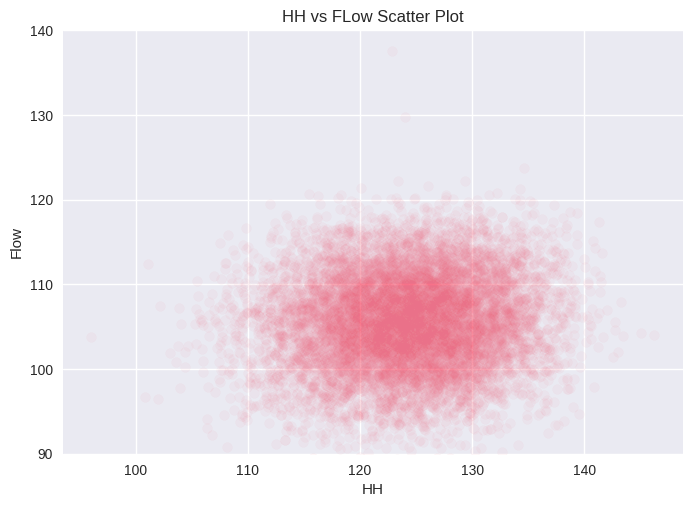

In [ ]:
plt.scatter(hutchinson_ll_full_filtered, flow_matching_ll_5000_filtered,alpha = 0.05)

plt.ylim(90,140)
# Add title and labels
plt.title('HH vs FLow Scatter Plot')
plt.xlabel('HH')
plt.ylabel('Flow')

# Display plot
plt.show()


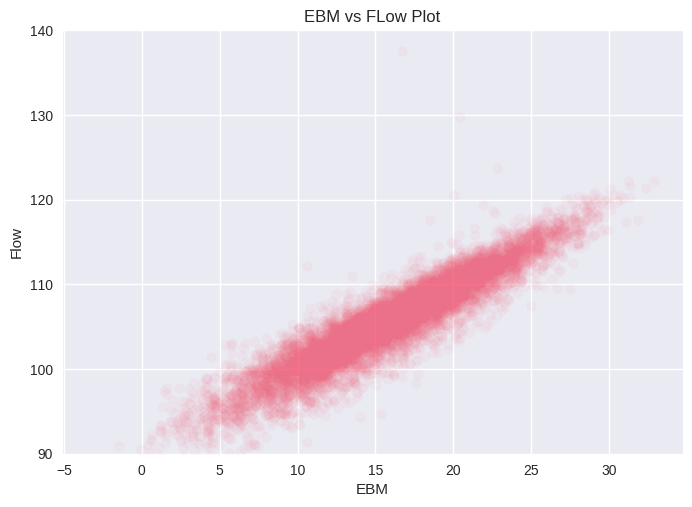

In [ ]:
plt.scatter(predicted_ebm_ll_5000_filtered, flow_matching_ll_5000_filtered,alpha = 0.05)

# Add title and labels
plt.title('EBM vs FLow Plot')
plt.ylim(90,140)

plt.xlabel('EBM')
plt.ylabel('Flow')

# Display plot
plt.show()


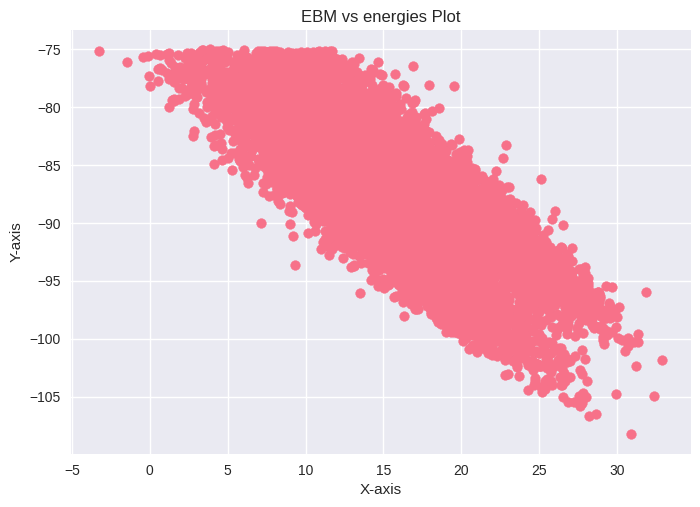

In [ ]:
plt.scatter(predicted_ebm_ll_5000_filtered, energies_5000_filtered)

# Add title and labels
plt.title('EBM vs energies Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display plot
plt.show()


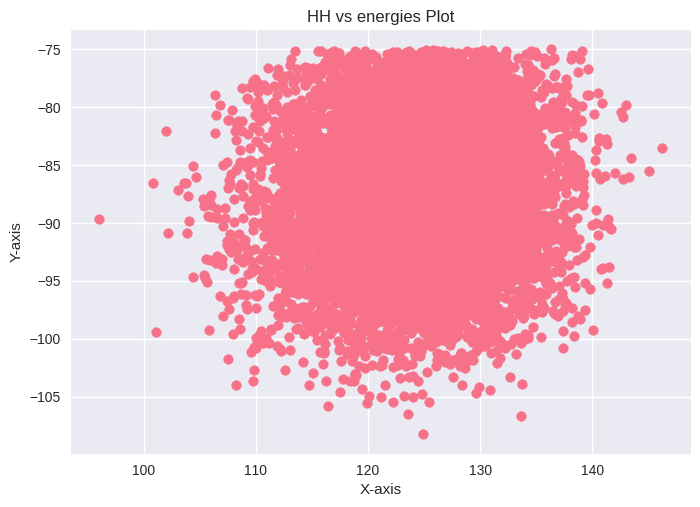

In [ ]:
plt.scatter(hutchinson_ll_full_filtered, energies_5000_filtered)

# Add title and labels
plt.title('HH vs energies Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display plot
plt.show()


## make plots for non filtered energies

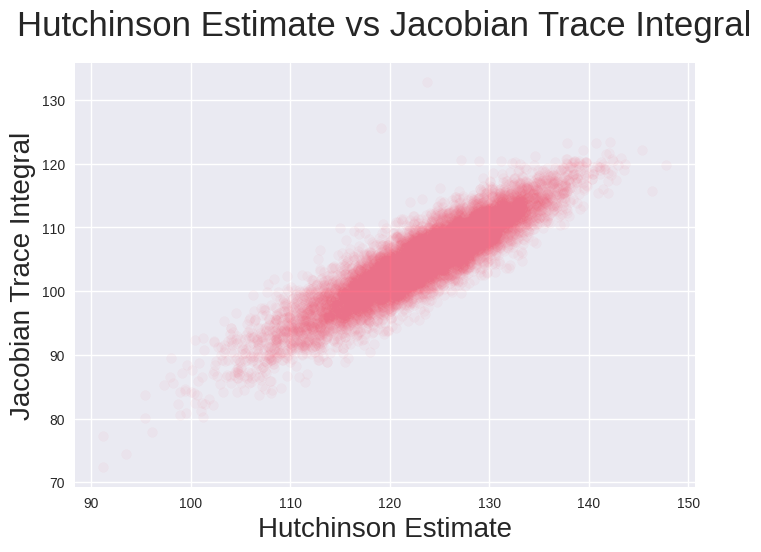

In [54]:

plt.scatter(hutchinson_ll_full, flow_matching_ll_5000,alpha=0.05)

# Add title and labels
plt.title('Hutchinson Estimate vs Jacobian Trace Integral',fontsize= 25,pad=20)
plt.xlabel('Hutchinson Estimate',fontsize= 20)
plt.ylabel('Jacobian Trace Integral',fontsize= 20)
plt.savefig("figures/hh_jactr_scatter.pdf")
# plt.plot( [70,150],[70,150],color = "black")
plt.xlim()
# Display plot
plt.show()


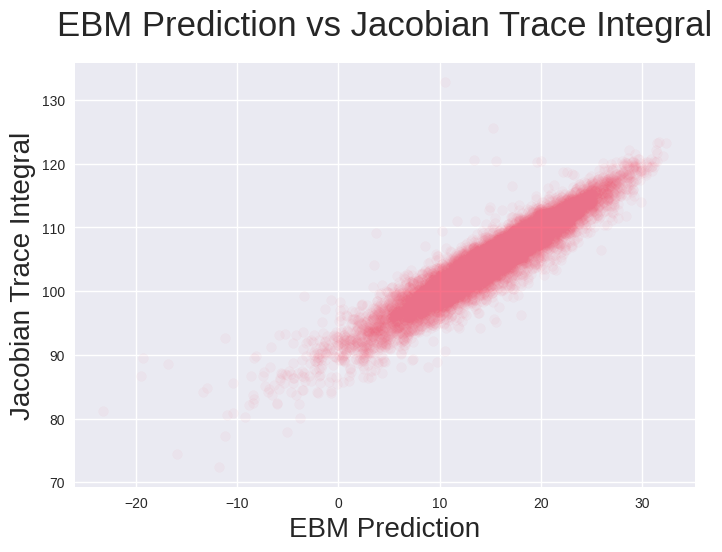

In [53]:
plt.scatter(predicted_ebm_ll_5000, flow_matching_ll_5000,alpha=0.05)

# Add title and labels
plt.title('EBM Prediction vs Jacobian Trace Integral',fontsize= 25,pad=20)
plt.xlabel('EBM Prediction',fontsize = 20)
plt.ylabel('Jacobian Trace Integral', fontsize = 20)
plt.savefig("figures/ebm_jactr_scatter.pdf")
# Display plot
plt.show()


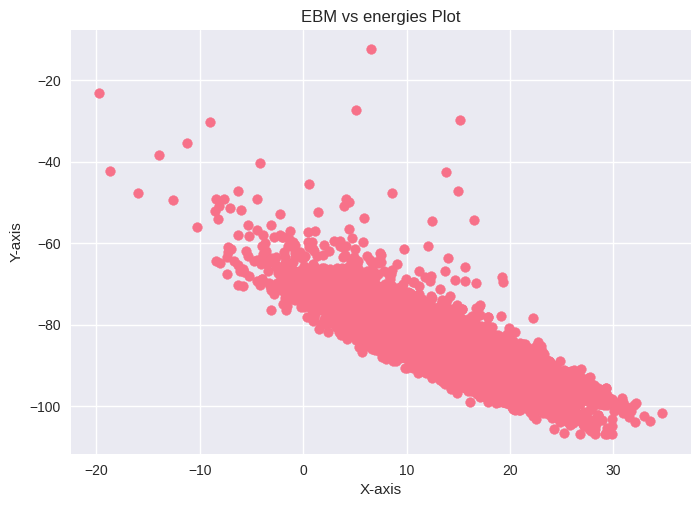

In [ ]:
plt.scatter(predicted_ebm_ll_5000, energies_5000)

# Add title and labels
plt.title('EBM vs energies Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display plot
plt.show()


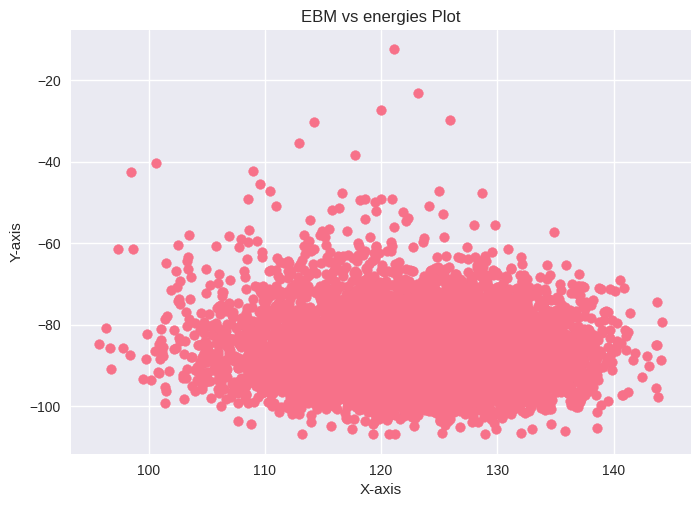

In [ ]:
plt.scatter(hutchinson_ll_full, energies_5000)

# Add title and labels
plt.title('hutchinson_ll_full vs energies Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display plot
plt.show()


In [ ]:
def calc_constant(Q,P):
    Q = torch.tensor(Q)
    P = torch.tensor(P)
    Q_normalizing = torch.logsumexp(Q,dim = 0)
    P_normalizing = torch.logsumexp(P, dim = 0)

    num = (Q - Q_normalizing.expand_as(Q))
    denom = (P - P_normalizing.expand_as(P))

    
    # return torch.logsumexp(num/denom,dim = 0) - torch.log(torch.tensor(P.shape[0]))
    return torch.logsumexp(num/denom,dim = 0) - torch.log(torch.tensor(P.shape[0])), Q_normalizing, P_normalizing

In [ ]:
# bias
# bias, Q_norm, P_norm = calc_constant(hutchinson_ll_full,flow_matching_ll_5000)
# P_norm
# torch.log(torch.tensor(hutchinson_ll_full.shape[0]))


NameError: name 'bias' is not defined

In [ ]:
bias, Q_norm, P_norm = calc_constant(hutchinson_ll_full_filtered,flow_matching_ll_5000_filtered)

temp_hutchinson =  hutchinson_ll_full_filtered- Q_norm.detach().cpu().numpy() 
temp_fm = flow_matching_ll_5000_filtered - P_norm.detach().cpu().numpy() 
# temp_fm = flow_matching_ll_5000 
plt.scatter(temp_hutchinson, temp_fm)

# Add title and labels
plt.title('EBM vs FLow Plot')
plt.xlabel('EBM')
plt.ylabel('Flow')

# Display plot
plt.show()

In [ ]:
calc_constant(predicted_ebm_ll_5000,flow_matching_ll_5000)

## Run HH with differnet numbers of function calls

In [ ]:
%load_ext autoreload
%autoreload 2
from importlib import reload
from models.interpolant import Interpolant
reload(Interpolant)

In [ ]:
from models.interpolant import Interpolant
# ============================================================================
# HUTCHINSON'S REVERSE INTEGRATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("              HUTCHINSON'S REVERSE INTEGRATION EXPERIMENT")
print("="*80)

# Run Hutchinson's analysis on both datasets if available
hutchinson_metrics = {}
potential_model, vector_field, interpolant_obj, = potential_model.to("cuda"), vector_field.to("cuda"), interpolant_obj.to("cuda")

# 1. Create a random permutation of indices 0..N-1
perm = np.random.permutation(samples_filtered.shape[0])

# 2. Select the first 5000 of those permuted indices
selected_idx = perm[:10000]
mask = mask = np.zeros(samples_filtered.shape[0], dtype=bool)
mask[selected_idx] = True


samples_5000_filtered = samples_filtered[mask]
energies_5000_filtered = energies_filtered[mask]
flow_matching_ll_5000_filtered = flow_matching_ll_filtered[mask]
predicted_ebm_ll_5000_filtered = predicted_ebm_ll_filtered[mask]

## wtwo function calls
m = 2

if samples_5000_filtered is not None or samples_filtered is not None:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_5000_filtered is not None:
        print(f"\n🔄 Computing Hutchinson's reverse integration (Full dataset: {len(samples_5000_filtered)} samples)")
        
        hutchinson_ll_full_filtered2 = get_hutchinson_likelihood_reverse(
            interpolant_obj, samples_5000_filtered, m, CONFIG['batch_size']  # Smaller batch for memory
        )
        print("hh.shape",hutchinson_ll_full_filtered2.shape)
        print("ebm.shape",predicted_ebm_ll_5000_filtered.shape)
        
        # Use EBM predictions from previous experiments if available
        if 'predicted_ebm_ll_full' in locals() and predicted_ebm_ll_5000_filtered is not None:
            print(f"\n📊 Comparing Hutchinson vs EBM (Full dataset)")
            
            metrics_full = run_single_experiment(
                4, "Hutchinson vs EBM", hutchinson_ll_full_filtered2, predicted_ebm_ll_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs flow", hutchinson_ll_full_filtered2, flow_matching_ll_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs Energies", hutchinson_ll_full_filtered2, energies_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
        #     hutchinson_metrics.update(hutchinson_ll_full_filtered)
            
        #     # Save Hutchinson predictions
        #     output_dir = Path(CONFIG['output_dir'])
        #     output_dir.mkdir(parents=True, exist_ok=True)
        #     np.save(output_dir / 'hutchinson_likelihoods_full.npy', hutchinson_ll_full)
        #     print(f"💾 Saved Hutchinson predictions (full): {output_dir / 'hutchinson_likelihoods_full.npy'}")
        # else:
        #     print("⚠️  EBM predictions not available for comparison with full dataset")
np.save("./generated/hutchinson_ll_full_m2.npy",hutchinson_ll_full_filtered2)

In [ ]:
from models.interpolant import Interpolant
# ============================================================================
# HUTCHINSON'S REVERSE INTEGRATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("              HUTCHINSON'S REVERSE INTEGRATION EXPERIMENT")
print("="*80)

# Run Hutchinson's analysis on both datasets if available
hutchinson_metrics = {}
potential_model, vector_field, interpolant_obj, = potential_model.to("cuda"), vector_field.to("cuda"), interpolant_obj.to("cuda")

# 1. Create a random permutation of indices 0..N-1
perm = np.random.permutation(samples_filtered.shape[0])

# 2. Select the first 5000 of those permuted indices
selected_idx = perm[:10000]
mask = mask = np.zeros(samples_filtered.shape[0], dtype=bool)
mask[selected_idx] = True


samples_5000_filtered = samples_filtered[mask]
energies_5000_filtered = energies_filtered[mask]
flow_matching_ll_5000_filtered = flow_matching_ll_filtered[mask]
predicted_ebm_ll_5000_filtered = predicted_ebm_ll_filtered[mask]

## wtwo function calls
m = 4

if samples_5000_filtered is not None or samples_filtered is not None:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_5000_filtered is not None:
        print(f"\n🔄 Computing Hutchinson's reverse integration (Full dataset: {len(samples_5000_filtered)} samples)")
        
        hutchinson_ll_full_filtered4 = get_hutchinson_likelihood_reverse(
            interpolant_obj, samples_5000_filtered, m, CONFIG['batch_size']  # Smaller batch for memory
        )
        print("hh.shape",hutchinson_ll_full_filtered4.shape)
        print("ebm.shape",predicted_ebm_ll_5000_filtered.shape)
        
        # Use EBM predictions from previous experiments if available
        if 'predicted_ebm_ll_full' in locals() and predicted_ebm_ll_5000_filtered is not None:
            print(f"\n📊 Comparing Hutchinson vs EBM (Full dataset)")
            
            metrics_full = run_single_experiment(
                4, "Hutchinson vs EBM", hutchinson_ll_full_filtered4, predicted_ebm_ll_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs flow", hutchinson_ll_full_filtered4, flow_matching_ll_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs Energies", hutchinson_ll_full_filtered4, energies_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
        #     hutchinson_metrics.update(hutchinson_ll_full_filtered)
            
        #     # Save Hutchinson predictions
        #     output_dir = Path(CONFIG['output_dir'])
        #     output_dir.mkdir(parents=True, exist_ok=True)
        #     np.save(output_dir / 'hutchinson_likelihoods_full.npy', hutchinson_ll_full)
        #     print(f"💾 Saved Hutchinson predictions (full): {output_dir / 'hutchinson_likelihoods_full.npy'}")
        # else:
        #     print("⚠️  EBM predictions not available for comparison with full dataset")
np.save("./generated/hutchinson_ll_full_m4.npy",hutchinson_ll_full_filtered4)

In [ ]:
# ============================================================================
# HUTCHINSON'S REVERSE INTEGRATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("              HUTCHINSON'S REVERSE INTEGRATION EXPERIMENT")
print("="*80)

# Run Hutchinson's analysis on both datasets if available
hutchinson_metrics = {}
potential_model, vector_field, interpolant_obj, = potential_model.to("cuda"), vector_field.to("cuda"), interpolant_obj.to("cuda")

# 1. Create a random permutation of indices 0..N-1
perm = np.random.permutation(samples_filtered.shape[0])

# 2. Select the first 5000 of those permuted indices
selected_idx = perm[:10000]
mask = mask = np.zeros(samples_filtered.shape[0], dtype=bool)
mask[selected_idx] = True


samples_5000_filtered = samples_filtered[mask]
energies_5000_filtered = energies_filtered[mask]
flow_matching_ll_5000_filtered = flow_matching_ll_filtered[mask]
predicted_ebm_ll_5000_filtered = predicted_ebm_ll_filtered[mask]

## wtwo function calls
m = 8

if samples_5000_filtered is not None or samples_filtered is not None:
    
    # Run on full dataset
    if CONFIG['run_full_analysis'] and samples_5000_filtered is not None:
        print(f"\n🔄 Computing Hutchinson's reverse integration (Full dataset: {len(samples_5000_filtered)} samples)")
        
        hutchinson_ll_full_filtered8 = get_hutchinson_likelihood_reverse(
            interpolant_obj, samples_5000_filtered, m, CONFIG['batch_size']  # Smaller batch for memory
        )
        print("hh.shape",hutchinson_ll_full_filtered8.shape)
        print("ebm.shape",predicted_ebm_ll_5000_filtered.shape)
        
        # Use EBM predictions from previous experiments if available
        if 'predicted_ebm_ll_full' in locals() and predicted_ebm_ll_5000_filtered is not None:
            print(f"\n📊 Comparing Hutchinson vs EBM (Full dataset)")
            
            metrics_full = run_single_experiment(
                4, "Hutchinson vs EBM", hutchinson_ll_full_filtered8, predicted_ebm_ll_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs flow", hutchinson_ll_full_filtered8, flow_matching_ll_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
            hutchinson_metrics.update(metrics_full)
            metrics_full = run_single_experiment(
                4, "Hutchinson vs Energies", hutchinson_ll_full_filtered8, energies_5000_filtered,
                samples_5000_filtered, "Full", CONFIG['output_dir']
            )
        #     hutchinson_metrics.update(hutchinson_ll_full_filtered)
            
        #     # Save Hutchinson predictions
        #     output_dir = Path(CONFIG['output_dir'])
        #     output_dir.mkdir(parents=True, exist_ok=True)
        #     np.save(output_dir / 'hutchinson_likelihoods_full.npy', hutchinson_ll_full)
        #     print(f"💾 Saved Hutchinson predictions (full): {output_dir / 'hutchinson_likelihoods_full.npy'}")
        # else:
        #     print("⚠️  EBM predictions not available for comparison with full dataset")
np.save("./generated/hutchinson_ll_full_m8.npy",hutchinson_ll_full_filtered8)